In [1]:
import warnings

from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

### DATA SOURCE: https://data.ibb.gov.tr/en/dataset/ulasim-yonetim-merkezi-trafik-duyuru-verisi

In [2]:
df = pd.read_csv("datasets/tr_traffic_announcement/traffic_announcement.csv")

In [3]:
df.duplicated().sum()

0

In [4]:
df.isnull().sum()

ANNOUNCEMENT_ID                       0
ANNOUNCEMENT_STARTING_DATETIME        0
ANNOUNCEMENT_ENDING_DATETIME          0
ANNOUNCEMENT_TITLE                    5
ANNOUNCEMENT_TEXT                     2
ANNOUNCEMENT_TYPE                     0
ANNOUNCEMENT_TYPE_DESC                2
INTERVENTION_DATETIME                10
ACCIDENT_STATUS                   57680
ACCIDENT_DESCRIPTION                 39
CLOSED_LANE                       46690
LONGITUDE                             0
LATITUDE                              0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160667 entries, 0 to 160666
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ANNOUNCEMENT_ID                 160667 non-null  int64  
 1   ANNOUNCEMENT_STARTING_DATETIME  160667 non-null  object 
 2   ANNOUNCEMENT_ENDING_DATETIME    160667 non-null  object 
 3   ANNOUNCEMENT_TITLE              160662 non-null  object 
 4   ANNOUNCEMENT_TEXT               160665 non-null  object 
 5   ANNOUNCEMENT_TYPE               160667 non-null  int64  
 6   ANNOUNCEMENT_TYPE_DESC          160665 non-null  object 
 7   INTERVENTION_DATETIME           160657 non-null  object 
 8   ACCIDENT_STATUS                 102987 non-null  float64
 9   ACCIDENT_DESCRIPTION            160628 non-null  object 
 10  CLOSED_LANE                     113977 non-null  float64
 11  LONGITUDE                       160667 non-null  object 
 12  LATITUDE        

# Cleaning Coordinates

In [6]:
# Replacing one row where there is a "," in the coordinates

df.loc[df['LONGITUDE'].str.contains(",", na=False), 'LONGITUDE']=\
df.loc[df['LONGITUDE'].str.contains(",", na=False), 'LONGITUDE'].replace(",", ".", regex=True)

In [7]:
df.loc[df['LATITUDE'].str.contains(",", na=False), 'LATITUDE']=\
df.loc[df['LATITUDE'].str.contains(",", na=False), 'LATITUDE'].replace(",", ".", regex=True)

In [8]:
# Converting to floats
df[['LONGITUDE', 'LATITUDE']] = df[['LONGITUDE', 'LATITUDE']].astype("float64")

#### Similar to traffic density dataset, most of the coordinates are interchanged

In [9]:
df[['LONGITUDE', 'LATITUDE']].describe().T

,count,mean,std,min,25%,50%,75%,max
LONGITUDE,160667.0,33.140766,7.659318,-1.000043,28.818451,28.999751,40.993210,2039.00000
LATITUDE,160667.0,36.786646,5.784022,-1.000257,29.009643,40.990327,41.032408,122.81327


#### The min and max values of the coordinates shows that there are some outliers. These needs to be handles. along with ensuring the proper latitude and longitude

In [10]:
# Preview of coordinates where Longitude is greater than 42
df.loc[df['LONGITUDE'].gt(42), ['LONGITUDE', 'LATITUDE']]

# Coordinates 43.405047	28.454589 points to Bulgaria

,LONGITUDE,LATITUDE
28057,43.405047,28.454589
34859,89.999999,25.538547
34957,90.000000,17.000000
36057,89.999997,122.813270
58152,2039.000000,41.057675


In [11]:
# Replacing the above rows with null values
df.loc[df['LONGITUDE'].gt(42), ['LONGITUDE', 'LATITUDE']] = np.nan

In [12]:
# Preview of coordinates where Longitude is lower than 28
df.loc[df['LONGITUDE'].lt(28), ['LONGITUDE', 'LATITUDE']].sort_values('LONGITUDE')

# Coordinates (27.725285, 42.534728) points to Saudi arabia. interchanging the coordinates (42.534728, 27.725285) point to some in the sea near Bulgaria

,LONGITUDE,LATITUDE
64528,-1.000043,-1.000257
123878,-1.000000,-1.000000
124567,-1.000000,-1.000000
113209,-1.000000,-1.000000
117553,-0.001502,41.092957
17066,0.000000,0.000000
22012,0.000000,0.000000
17882,0.000515,0.001373
22634,0.001674,0.001888
135892,0.002961,41.088107


In [13]:
# Replacing these rows with null values
df.loc[df['LONGITUDE'].lt(28), ['LONGITUDE', 'LATITUDE']] = np.nan

In [14]:
# Preview of coordinates where LATITUDE is lower than 28
df.loc[df['LATITUDE'].lt(28), ['LONGITUDE', 'LATITUDE']]

# Coordinates 41.173975	23.420000 points to somewhere in Greece

,LONGITUDE,LATITUDE
68221,40.970046,0.001116
74484,41.173975,23.420000
81817,41.001524,-0.000172
83521,41.147665,-0.001019
99695,41.147681,-0.000687


In [15]:
# Replacing these rows with null values
df.loc[df['LATITUDE'].lt(28), ['LONGITUDE', 'LATITUDE']] = np.nan

In [16]:
# Preview of coordinates where LATITUDE is greater than 42
df.loc[df['LATITUDE'].gt(42), ['LONGITUDE', 'LATITUDE']]

,LONGITUDE,LATITUDE
30400,39.50404,51.503906


In [17]:
# Replacing these rows with null values
df.loc[df['LATITUDE'].gt(42), ['LONGITUDE', 'LATITUDE']] = np.nan

#### Outliers in the dataset has been taken care of. Now, I will ensure the coordinates are in the right columns.

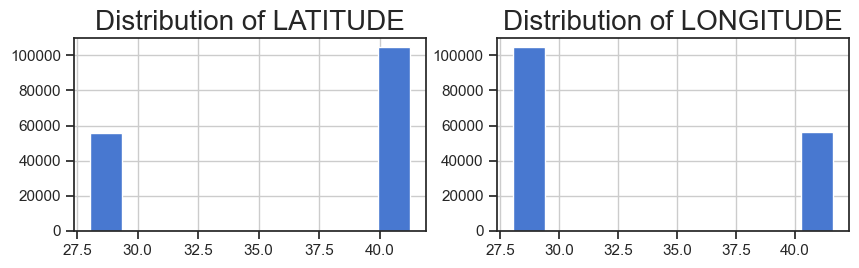

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))

df['LATITUDE'].hist(ax=ax[0])
ax[0].set_title("Distribution of LATITUDE")

df['LONGITUDE'].hist(ax=ax[1])
ax[1].set_title("Distribution of LONGITUDE");

In [19]:
actual_long = df.loc[df['LATITUDE'].lt(39), 'LATITUDE']
actual_lat = df.loc[df['LATITUDE'].lt(39), 'LONGITUDE']

df.loc[df['LATITUDE'].lt(39), 'LONGITUDE'] = actual_long
df.loc[df['LATITUDE'].lt(39), 'LATITUDE'] = actual_lat

In [20]:
# Still some outliers remains
df.loc[df['LATITUDE'].le(40), ['LATITUDE', 'LONGITUDE']] = np.nan

In [21]:
df.loc[df['LONGITUDE'].ge(29.56), ['LATITUDE', 'LONGITUDE']] = np.nan

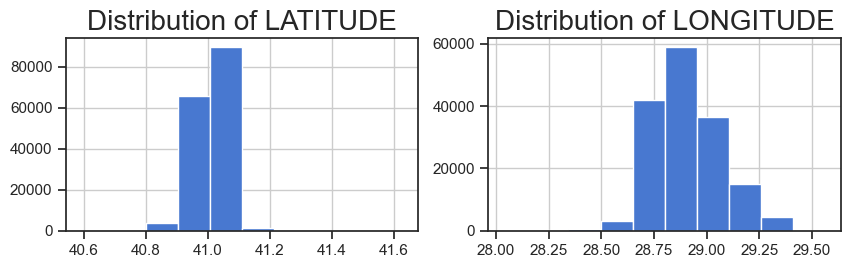

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))

df['LATITUDE'].hist(ax=ax[0])
ax[0].set_title("Distribution of LATITUDE")

df['LONGITUDE'].hist(ax=ax[1])
ax[1].set_title("Distribution of LONGITUDE");

### For now, the coordinates looks within the correct limits.

### **One of the future tasks could be to try impute the missing values of coordinates by inferring the locations from one of the string columns.** 

In [23]:
df['LATITUDE'].isnull().sum()

36

## Cleaning Date Columns

In [24]:
# Converting datetime columns to pandas datetime format
date_cols=[col for col in df.columns if col.endswith("_DATETIME")]
date_cols

['ANNOUNCEMENT_STARTING_DATETIME',
 'ANNOUNCEMENT_ENDING_DATETIME',
 'INTERVENTION_DATETIME']

In [25]:
df[date_cols].head()

,ANNOUNCEMENT_STARTING_DATETIME,ANNOUNCEMENT_ENDING_DATETIME,INTERVENTION_DATETIME
0,2013-02-12 14:29:39.94 +0000 +0000,2013-02-12 15:12:43 +0000 +0000,2013-02-12 15:12:43 +0000 +0000
1,2013-02-18 08:48:15.21 +0000 +0000,2013-02-18 10:37:24 +0000 +0000,2013-02-18 10:37:24 +0000 +0000
2,2013-02-25 10:33:39.77 +0000 +0000,2013-02-25 13:18:59 +0000 +0000,2013-02-25 13:18:59 +0000 +0000
3,2013-02-25 11:43:14.27 +0000 +0000,2013-02-25 12:30:00.61 +0000 +0000,2013-02-25 12:30:00.61 +0000 +0000
4,2013-02-25 12:07:50.58 +0000 +0000,2013-02-25 12:54:36.9 +0000 +0000,2013-02-25 12:54:36.9 +0000 +0000


In [26]:
for col in date_cols:
    df[col] = pd.to_datetime(df[col].str.extract(r'^(.+:\d{2})[\.\d]* \+\d{4} \+\d{4}$', expand=False))

In [27]:
df[["ANNOUNCEMENT_ENDING_DATETIME", "INTERVENTION_DATETIME"]].head()

,ANNOUNCEMENT_ENDING_DATETIME,INTERVENTION_DATETIME
0,2013-02-12 15:12:43,2013-02-12 15:12:43
1,2013-02-18 10:37:24,2013-02-18 10:37:24
2,2013-02-25 13:18:59,2013-02-25 13:18:59
3,2013-02-25 12:30:00,2013-02-25 12:30:00
4,2013-02-25 12:54:36,2013-02-25 12:54:36


In [28]:
(df["ANNOUNCEMENT_ENDING_DATETIME"]!=df["INTERVENTION_DATETIME"]).sum()

8256

#### Most of the dates from ANNOUNCEMENT_ENDING_DATETIME and INTERVENTION_DATETIME are exactly same, except for around 8k rows. There are around 10 null values in INTERVENTION_DATETIME columns. For now, I will impute them using date from ANNOUNCEMENT_ENDING_DATETIME.

In [29]:
df.loc[df['INTERVENTION_DATETIME'].isnull(), 'INTERVENTION_DATETIME']=\
df.loc[df['INTERVENTION_DATETIME'].isnull(), 'ANNOUNCEMENT_ENDING_DATETIME']

## ANNOUNCEMENT TYPE

In [30]:
# ANNOUNCEMENT_ID are all unique
df["ANNOUNCEMENT_ID"].value_counts().sort_values()

ANNOUNCEMENT_ID
32396     1
36492     1
36025     1
36024     1
33201     1
         ..
920173    1
920180    1
920181    1
920163    1
920186    1
Name: count, Length: 160667, dtype: int64

In [31]:
df["ANNOUNCEMENT_TYPE"].value_counts()

ANNOUNCEMENT_TYPE
16    77916
32    54947
17    17463
23     5811
35     1328
18     1260
24      563
36      449
34      375
38      221
30      118
39       63
31       50
37       45
19       42
33       11
0         2
26        1
20        1
21        1
Name: count, dtype: int64

In [32]:
df["ANNOUNCEMENT_TYPE_DESC"].value_counts()

ANNOUNCEMENT_TYPE_DESC
Kaza Bildirimi                   77916
Araç Arızası                     54947
Bakım-Onarım Çalışması           17463
Yoğun Trafik                      5811
Çevre Düzenlemesi                 1328
Yolun Trafiğe Kapanması           1260
Haber                              563
Araç Yangını                       449
Yol Yapım Çalışması                375
Alt Yapı Çalışması                 221
İDO Sefer Bildirisi                118
Şehir Hatları Sefer Bildirisi       63
Diğer                               50
İmalat Çalışması                    45
Yolu Etkileyen Hava Koşulu          42
Kontrollü Kapama (Protokol)         11
Kavşak Durumları                     1
Yeni Kamera                          1
Yeni Sensör                          1
Name: count, dtype: int64

In [33]:
df[["ANNOUNCEMENT_TYPE", "ANNOUNCEMENT_TYPE_DESC"]].drop_duplicates(ignore_index=True)

,ANNOUNCEMENT_TYPE,ANNOUNCEMENT_TYPE_DESC
0,17,Bakım-Onarım Çalışması
1,23,Yoğun Trafik
2,16,Kaza Bildirimi
3,18,Yolun Trafiğe Kapanması
4,32,Araç Arızası
5,30,İDO Sefer Bildirisi
6,39,Şehir Hatları Sefer Bildirisi
7,24,Haber
8,31,Diğer
9,34,Yol Yapım Çalışması


### ANNOUNCEMENT_TYPE and ANNOUNCEMENT_TYPE_DESC refers to the same thing.

In [34]:
# #https://github.com/Saravananslb/py-googletranslation/issues/8#issuecomment-882949604
# def translate_word(word_to_translate):
    
#     tries = 1
#     while tries <= 10:
#         try:
#             translator = Translator()
#             translator.raise_Exception = True
#             translated_text = translator.translate(word_to_translate, src='tr', dest='en').text
#             return translated_text
        
#         except TypeError:
#             tries += 1
#             time.sleep(2)

In [35]:
# ancmnt_type_dict = {word:translate_word(word) for word in tqdm(df["ANNOUNCEMENT_TYPE_DESC"].unique())}
# ancmnt_type_dict

In [36]:
# Saving the translated results since the translation takes time.
ancmnt_type_dict = {
    'Bakım-Onarım Çalışması': 'Maintenance-Investment Work',
    'Yoğun Trafik': 'Heavy traffic',
    'Kaza Bildirimi': 'Accident notification',
    'Yolun Trafiğe Kapanması': 'The closure of the road to traffic',
    'Araç Arızası': 'Vehicle failure',
    'İDO Sefer Bildirisi': 'Ido Expedition Declaration',
    'Şehir Hatları Sefer Bildirisi': 'City Lines Expedition Declaration',
    'Haber': 'News',
    'Diğer': 'Other',
    'Yol Yapım Çalışması': 'Road construction work',
    'Çevre Düzenlemesi': 'Landscaping',
    'Yolu Etkileyen Hava Koşulu': 'Air condition affecting the road',
    'Araç Yangını': 'Vehicle fire',
    'Kontrollü Kapama (Protokol)': 'Controlled Closing (Protocol)',
    'Alt Yapı Çalışması': 'Infrastructure work',
    'İmalat Çalışması': 'Manufacturing work',
    'Kavşak Durumları': 'Junction Situations',
    'Yeni Kamera': 'New camera',
    'Yeni Sensör': 'New sensor'
 }

In [37]:
df['ANNOUNCEMENT_TYPE_DESC'] = df['ANNOUNCEMENT_TYPE_DESC'].map(ancmnt_type_dict)

In [38]:
df['ANNOUNCEMENT_TYPE_DESC'].value_counts()

ANNOUNCEMENT_TYPE_DESC
Accident notification                 77916
Vehicle failure                       54947
Maintenance-Investment Work           17463
Heavy traffic                          5811
Landscaping                            1328
The closure of the road to traffic     1260
News                                    563
Vehicle fire                            449
Road construction work                  375
Infrastructure work                     221
Ido Expedition Declaration              118
City Lines Expedition Declaration        63
Other                                    50
Manufacturing work                       45
Air condition affecting the road         42
Controlled Closing (Protocol)            11
Junction Situations                       1
New camera                                1
New sensor                                1
Name: count, dtype: int64

# Around 78k announcements from 2013 to present were related to traffic accidents

In [39]:
# This row is actually has no usefull information. The coordinates point to somewhere in the sea, south of Eurasia Tunnel.

df.loc[df['ANNOUNCEMENT_TYPE_DESC'].isnull()]

,ANNOUNCEMENT_ID,ANNOUNCEMENT_STARTING_DATETIME,ANNOUNCEMENT_ENDING_DATETIME,ANNOUNCEMENT_TITLE,ANNOUNCEMENT_TEXT,ANNOUNCEMENT_TYPE,ANNOUNCEMENT_TYPE_DESC,INTERVENTION_DATETIME,ACCIDENT_STATUS,ACCIDENT_DESCRIPTION,CLOSED_LANE,LONGITUDE,LATITUDE
121386,591974,2020-09-22 20:47:55,2020-09-22 21:17:55,0,0,0,NaN,2020-09-22 21:17:55,NaN,-1,0.0,29.0,41.0
131619,685087,2021-03-31 14:43:42,2021-03-31 15:13:42,0,0,0,NaN,2021-03-31 15:13:42,NaN,-1,0.0,29.0,41.0


In [40]:
df = df[df['ANNOUNCEMENT_TYPE_DESC'].notnull()].reset_index(drop=True)

In [41]:
df.columns

Index(['ANNOUNCEMENT_ID', 'ANNOUNCEMENT_STARTING_DATETIME',
       'ANNOUNCEMENT_ENDING_DATETIME', 'ANNOUNCEMENT_TITLE',
       'ANNOUNCEMENT_TEXT', 'ANNOUNCEMENT_TYPE', 'ANNOUNCEMENT_TYPE_DESC',
       'INTERVENTION_DATETIME', 'ACCIDENT_STATUS', 'ACCIDENT_DESCRIPTION',
       'CLOSED_LANE', 'LONGITUDE', 'LATITUDE'],
      dtype='object')

In [42]:
# Now clear what this column represents
df['ACCIDENT_STATUS'].value_counts()

ACCIDENT_STATUS
 2.0    51967
-1.0    25090
 1.0    16136
 7.0     5983
 8.0     2968
 5.0      532
 0.0      127
 6.0       98
 3.0       46
 4.0       40
Name: count, dtype: int64

In [43]:
df['ACCIDENT_DESCRIPTION'].value_counts()

ACCIDENT_DESCRIPTION
-1                             82749
trafik kazası (hasarlı)        57756
trafik kazası (yaralanmalı)     9908
trafik kazası (zincirleme)      9852
trafik kazası (can kaybı)        340
Bilgi yok                         21
Name: count, dtype: int64

In [44]:
acc_desc={
    '-1' : '-1',
    'trafik kazası (hasarlı)' : 'traffic accident (damaged)',
    'trafik kazası (yaralanmalı)' : 'traffic accident (must be injured)',
    'trafik kazası (zincirleme)' : 'traffic accident (chain)',
    'trafik kazası (can kaybı)' : 'traffic accident (loss of life)',
    'Bilgi yok' : 'No information'
}

In [45]:
df['ACCIDENT_DESCRIPTION'] = df['ACCIDENT_DESCRIPTION'].map(acc_desc)

In [46]:
df['ACCIDENT_DESCRIPTION'].value_counts()

ACCIDENT_DESCRIPTION
-1                                    82749
traffic accident (damaged)            57756
traffic accident (must be injured)     9908
traffic accident (chain)               9852
traffic accident (loss of life)         340
No information                           21
Name: count, dtype: int64

In [47]:
df.query("ACCIDENT_DESCRIPTION=='-1' and ANNOUNCEMENT_TYPE_DESC.notnull()")['ANNOUNCEMENT_TYPE_DESC'].unique()

array(['Maintenance-Investment Work', 'Heavy traffic',
       'The closure of the road to traffic', 'Vehicle failure',
       'Ido Expedition Declaration', 'City Lines Expedition Declaration',
       'News', 'Other', 'Road construction work', 'Landscaping',
       'Air condition affecting the road', 'Vehicle fire',
       'Controlled Closing (Protocol)', 'Infrastructure work',
       'Manufacturing work', 'Junction Situations', 'New camera',
       'New sensor'], dtype=object)

### ACCIDENT_DESCRIPTION = -1 represents other categories other than accidents

In [48]:
df.query("ACCIDENT_DESCRIPTION=='No information'")['ANNOUNCEMENT_TYPE_DESC'].unique()

array(['Accident notification'], dtype=object)

In [49]:
df.query("ACCIDENT_DESCRIPTION=='No information'")['ANNOUNCEMENT_TITLE'].unique()

array(['D100 İncirli-Şirinevler Yönü Trafik kazası (zincirleme)',
       'Çapa-Aksaray Trafik kazası (hasarlı)',
       'D100 Haliç-Okmeydanı Yönü Trafik kazası (zincirleme)',
       'D100 Kozyatağı-Bostancı Yönü Trafik kazası (hasarlı)',
       'Halkalı - İkitelli (yan yol) Yönü Trafik kazası (hasarlı)',
       'D100 Merter-Cevizlibağ Yönü Trafik kazası (hasarlı)',
       'D100 Pendik-Kartal Yönü Trafik kazası (hasarlı)',
       'D100 Bostancı-Kozyatağı Yönü Trafik kazası (hasarlı)',
       'Tem Hasdal-Seyrantepe Yönü Trafik kazası (hasarlı)',
       'D100 Avcılar-Hacışerif Yönü Trafik kazası!',
       'Bayrampaşa Yıldırım-Otagar  Trafik kazası (hasarlı)',
       'D100 Çobançeşme-Sefaköy Yönü Trafik kazası (hasarlı)',
       'D100 İncirli-Şirinevler Yönü Trafik kazası (hasarlı)',
       'Aksaray-Çapa Trafik kazası (hasarlı)',
       'TEM Orhanlı-Aydınlı Dericiler Yönü Trafik kazası (hasarlı)',
       'D100 Hacışerif-Avcılar Yönü Trafik kazası (hasarlı)',
       'D100 İncirli(yan yol)-

#### From the above texts, it is clear that the type and severity of the accidents is available in the ANNOUNCEMENT_TITLE columns when ACCIDENT_DESCRIPTION='No information'. I will replace no information with the right information.

In [50]:
df.loc[df['ACCIDENT_DESCRIPTION'].eq('No information'), 'ACCIDENT_DESCRIPTION'] = \
(
    df.loc[df['ACCIDENT_DESCRIPTION'].eq('No information'), 'ANNOUNCEMENT_TITLE']
    .str.extract(r'(Trafik.+)$', expand=False)
    .str.lower()
    .map(acc_desc)
    .fillna("traffic accident (damaged)") # checked the corresponding ANNOUNCEMENT_TEXT and got the right accident category
)

In [51]:
df['ACCIDENT_DESCRIPTION'].value_counts()

ACCIDENT_DESCRIPTION
-1                                    82749
traffic accident (damaged)            57775
traffic accident (must be injured)     9908
traffic accident (chain)               9854
traffic accident (loss of life)         340
Name: count, dtype: int64

In [52]:
acc_desc

{'-1': '-1',
 'trafik kazası (hasarlı)': 'traffic accident (damaged)',
 'trafik kazası (yaralanmalı)': 'traffic accident (must be injured)',
 'trafik kazası (zincirleme)': 'traffic accident (chain)',
 'trafik kazası (can kaybı)': 'traffic accident (loss of life)',
 'Bilgi yok': 'No information'}

#### Checking those rows where ACCIDENT_DESCRIPTION is null and try to fill with appropriate information

In [53]:
# Checkin the row contains the keyword 'hasarlı' (damaged) in ANNOUNCEMENT_TEXT
df.loc[
    df['ACCIDENT_DESCRIPTION'].isnull() & 
    df['ANNOUNCEMENT_TEXT'].str.contains('hasarlı', case=False), 
    'ACCIDENT_DESCRIPTION'
] = 'traffic accident (damaged)'

In [54]:
# Checkin the row contains the keyword 'yaralanmalı' (must be injured) in ANNOUNCEMENT_TEXT
df.loc[
    df['ACCIDENT_DESCRIPTION'].isnull() & 
    df['ANNOUNCEMENT_TEXT'].str.contains('yaralanmalı', case=False), 
    'ACCIDENT_DESCRIPTION'
] = 'traffic accident (must be injured)'

In [55]:
# Checked for other keywords. None were present. Therefore, imputting the rest of null values in ACCIDENT_DESCRIPTION with 'traffic accident (unknown)'
df['ACCIDENT_DESCRIPTION'] = df['ACCIDENT_DESCRIPTION'].fillna('traffic accident (unknown)')

In [56]:
df['ACCIDENT_DESCRIPTION'].value_counts()

ACCIDENT_DESCRIPTION
-1                                    82749
traffic accident (damaged)            57781
traffic accident (must be injured)     9911
traffic accident (chain)               9854
traffic accident (loss of life)         340
traffic accident (unknown)               30
Name: count, dtype: int64

In [57]:
df.isnull().sum()

ANNOUNCEMENT_ID                       0
ANNOUNCEMENT_STARTING_DATETIME        0
ANNOUNCEMENT_ENDING_DATETIME          0
ANNOUNCEMENT_TITLE                    5
ANNOUNCEMENT_TEXT                     2
ANNOUNCEMENT_TYPE                     0
ANNOUNCEMENT_TYPE_DESC                0
INTERVENTION_DATETIME                 0
ACCIDENT_STATUS                   57678
ACCIDENT_DESCRIPTION                  0
CLOSED_LANE                       46690
LONGITUDE                            36
LATITUDE                             36
dtype: int64

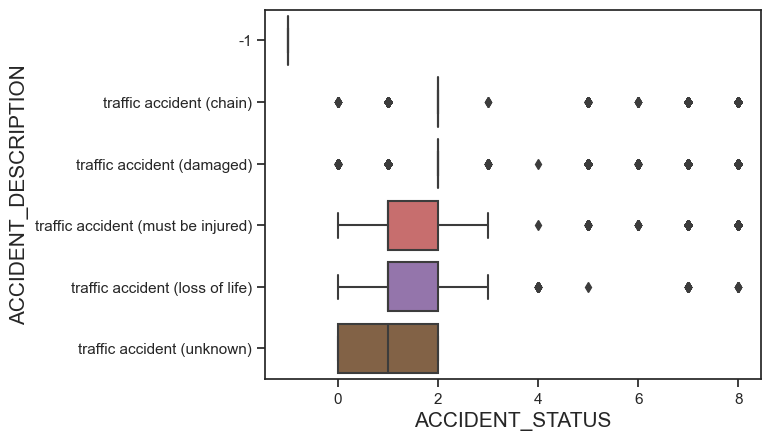

In [58]:
sns.boxplot(
    x='ACCIDENT_STATUS',
    y='ACCIDENT_DESCRIPTION',
    data=df,
    orient='h'
);

#### The above plot shows the distribution of ACCIDENT_STATUS for each ACCIDENT_DESCRIPTION category. This column might indicate the number of people affected by the accident?

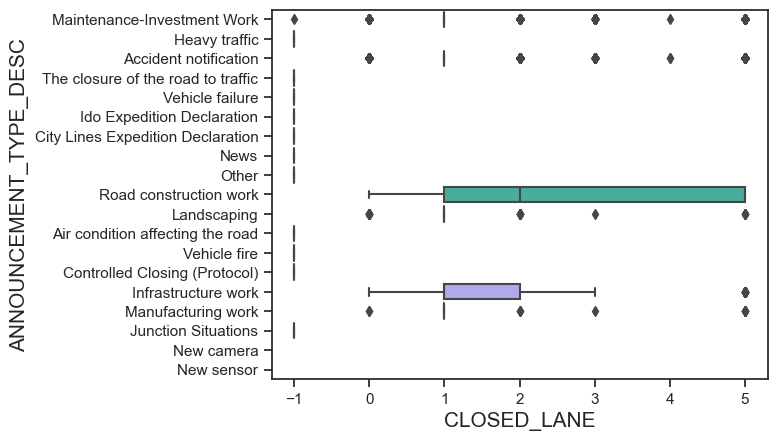

In [59]:
sns.boxplot(
    x='CLOSED_LANE',
    y='ANNOUNCEMENT_TYPE_DESC',
    data=df,
    orient='h'
);

#### The above plot shows the number of lanes closed according to the type of announcement (ANNOUNCEMENT_TYPE_DESC). The some number of lanes are closed mostly for Road construction work or infrastructure work. No lanes are closed for New Camera or new sensor categories. Closed_LANES=-1 represents non relvant information i believe.

## When was the last time this dataset was updated?

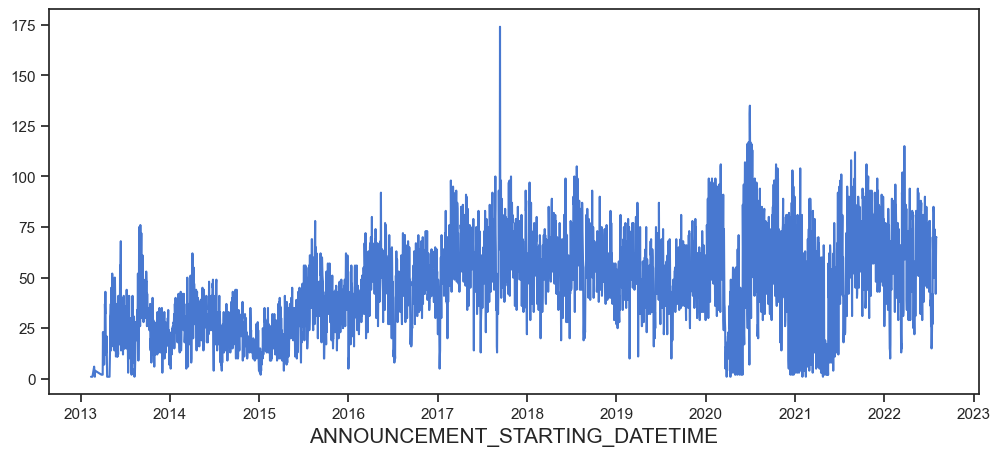

In [60]:
(
    df.groupby(df['ANNOUNCEMENT_STARTING_DATETIME'].dt.date)['ANNOUNCEMENT_TYPE_DESC'].size()
    .plot(figsize=(12, 5))
);

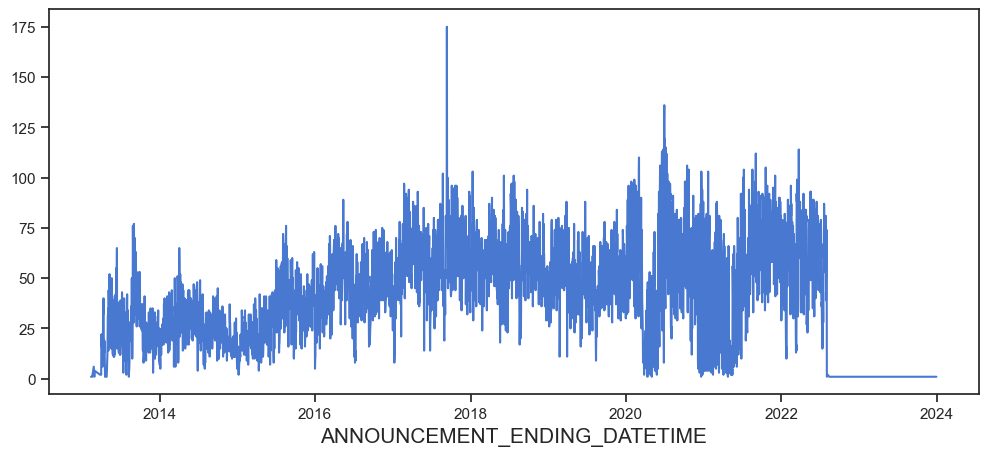

In [61]:
(
    df.groupby(df['ANNOUNCEMENT_ENDING_DATETIME'].dt.date)['ANNOUNCEMENT_TYPE_DESC'].size()
    .plot(figsize=(12, 5))
);

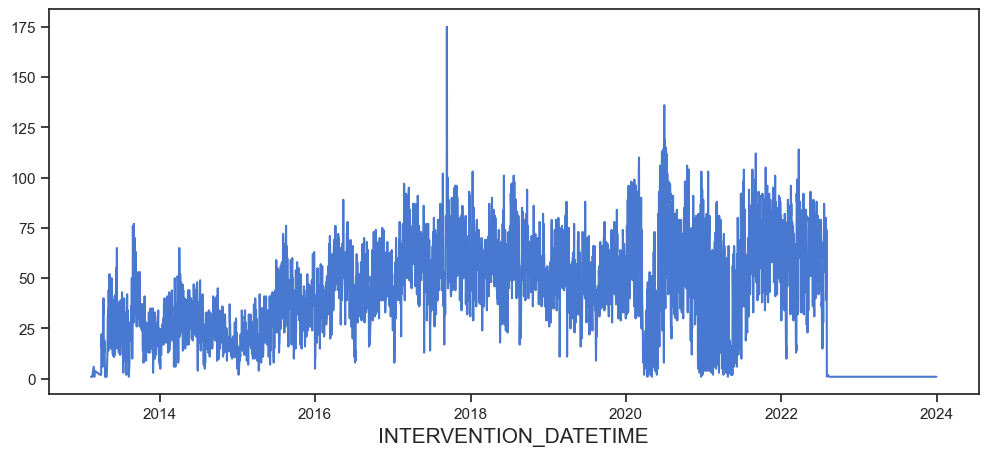

In [62]:
(
    df.groupby(df['INTERVENTION_DATETIME'].dt.date)['ANNOUNCEMENT_TYPE_DESC'].size()
    .plot(figsize=(12, 5))
);

## From the the above plots of each date types, it seems the data is only available untill August of 2022. We need to get latest data from Aug 2022 to April 2023.

In [63]:
# Looking closly at the spike in the time series data
df.groupby(df['ANNOUNCEMENT_STARTING_DATETIME'].dt.date)['ANNOUNCEMENT_TYPE_DESC'].size().nlargest(1)

ANNOUNCEMENT_STARTING_DATETIME
2017-09-12    174
Name: ANNOUNCEMENT_TYPE_DESC, dtype: int64

In [64]:
df.loc[df['ANNOUNCEMENT_STARTING_DATETIME'].between("2017-09-12", "2017-09-13"), "ANNOUNCEMENT_TYPE_DESC"].value_counts()

ANNOUNCEMENT_TYPE_DESC
Maintenance-Investment Work    95
Accident notification          40
Vehicle failure                32
Landscaping                     4
Heavy traffic                   2
Road construction work          1
Name: count, dtype: int64

#### on 12th September 2017, there was an unusually high announcements related to Maintenance-Investment Work.

In [65]:
df.query("ANNOUNCEMENT_TYPE_DESC=='Accident notification'")['ANNOUNCEMENT_STARTING_DATETIME'].nlargest(5)

160664   2022-08-02 18:42:33
160663   2022-08-02 18:38:29
160662   2022-08-02 18:37:26
160661   2022-08-02 18:31:28
160660   2022-08-02 18:19:49
Name: ANNOUNCEMENT_STARTING_DATETIME, dtype: datetime64[ns]

In [66]:
df.query("ANNOUNCEMENT_TYPE_DESC=='Accident notification'")['ANNOUNCEMENT_ENDING_DATETIME'].nlargest(5)

160664   2022-08-02 20:30:00
160662   2022-08-02 19:13:00
160661   2022-08-02 19:07:00
160663   2022-08-02 19:07:00
160660   2022-08-02 18:59:00
Name: ANNOUNCEMENT_ENDING_DATETIME, dtype: datetime64[ns]

In [67]:
df.query("ANNOUNCEMENT_TYPE_DESC=='Accident notification'")['INTERVENTION_DATETIME'].nlargest(5)

160664   2022-08-02 20:30:00
160662   2022-08-02 19:13:00
160661   2022-08-02 19:07:00
160663   2022-08-02 19:07:00
160660   2022-08-02 18:59:00
Name: INTERVENTION_DATETIME, dtype: datetime64[ns]

# The last time an accident announcement was on August 2022. Since then no update regarding accidents were made. Its possible that this dataset is currently incomplete and has not been updated for a while.

In [68]:
# df.to_csv("cleaned_traffic_ancmnt_rev01.csv", index=False)

In [69]:
df = df.assign(
    YEAR=df['INTERVENTION_DATETIME'].dt.year,
    MONTH=df['INTERVENTION_DATETIME'].dt.month,
    DAY=df['INTERVENTION_DATETIME'].dt.day,
    HOUR=df['INTERVENTION_DATETIME'].dt.hour,
    DAYOFWEEK=df['INTERVENTION_DATETIME'].dt.dayofweek
)

# Accident Patterns

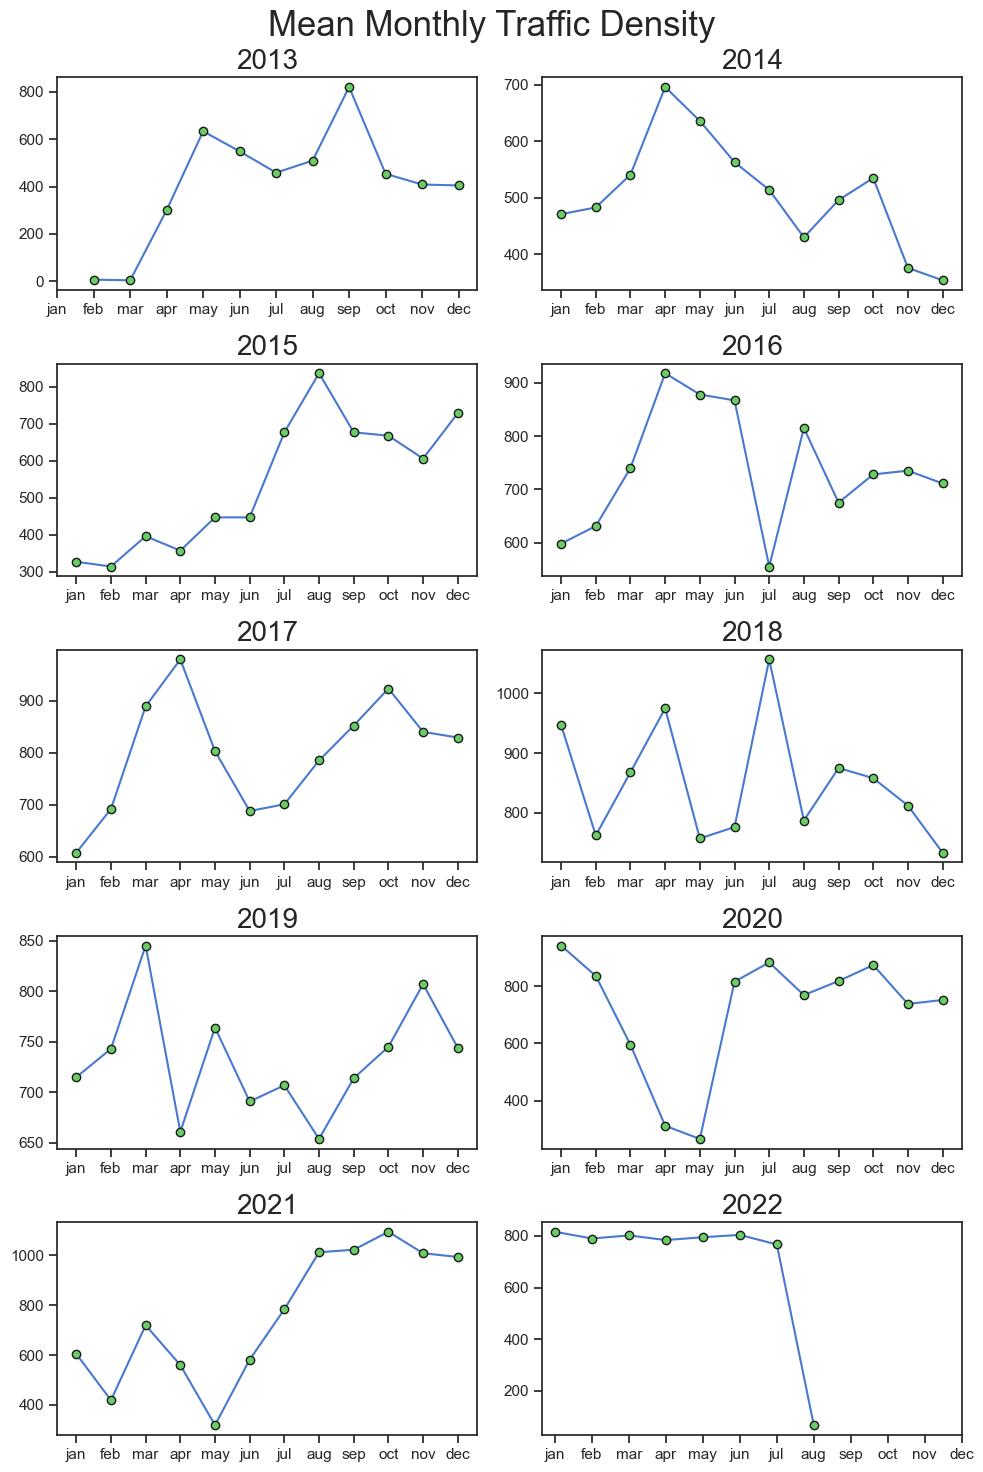

In [70]:
# Plotting Monthly Patterns
month_labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, axes = plt.subplots(5, 2, figsize=(10, 15), tight_layout=True)

for year, ax in zip(np.sort(df['YEAR'].unique()), axes.flatten()):
    (
        df.query(f"ANNOUNCEMENT_TYPE_DESC=='Accident notification' and YEAR=={year}")
        .groupby('MONTH').size()
        .plot(ax=ax, marker="o", mfc="g", mec="k")
    );

    ax.set_title(year)
    ax.set_xlabel("")
    
    ax.set_xticks(ticks=np.arange(1, 13, 1), labels=month_labels)

plt.suptitle("Mean Monthly Traffic Density", size=25);

### There is no discernable monthly seasonality to accident reportings. Its not clear whether this because of the way how accident incidents are recorded and announced. 

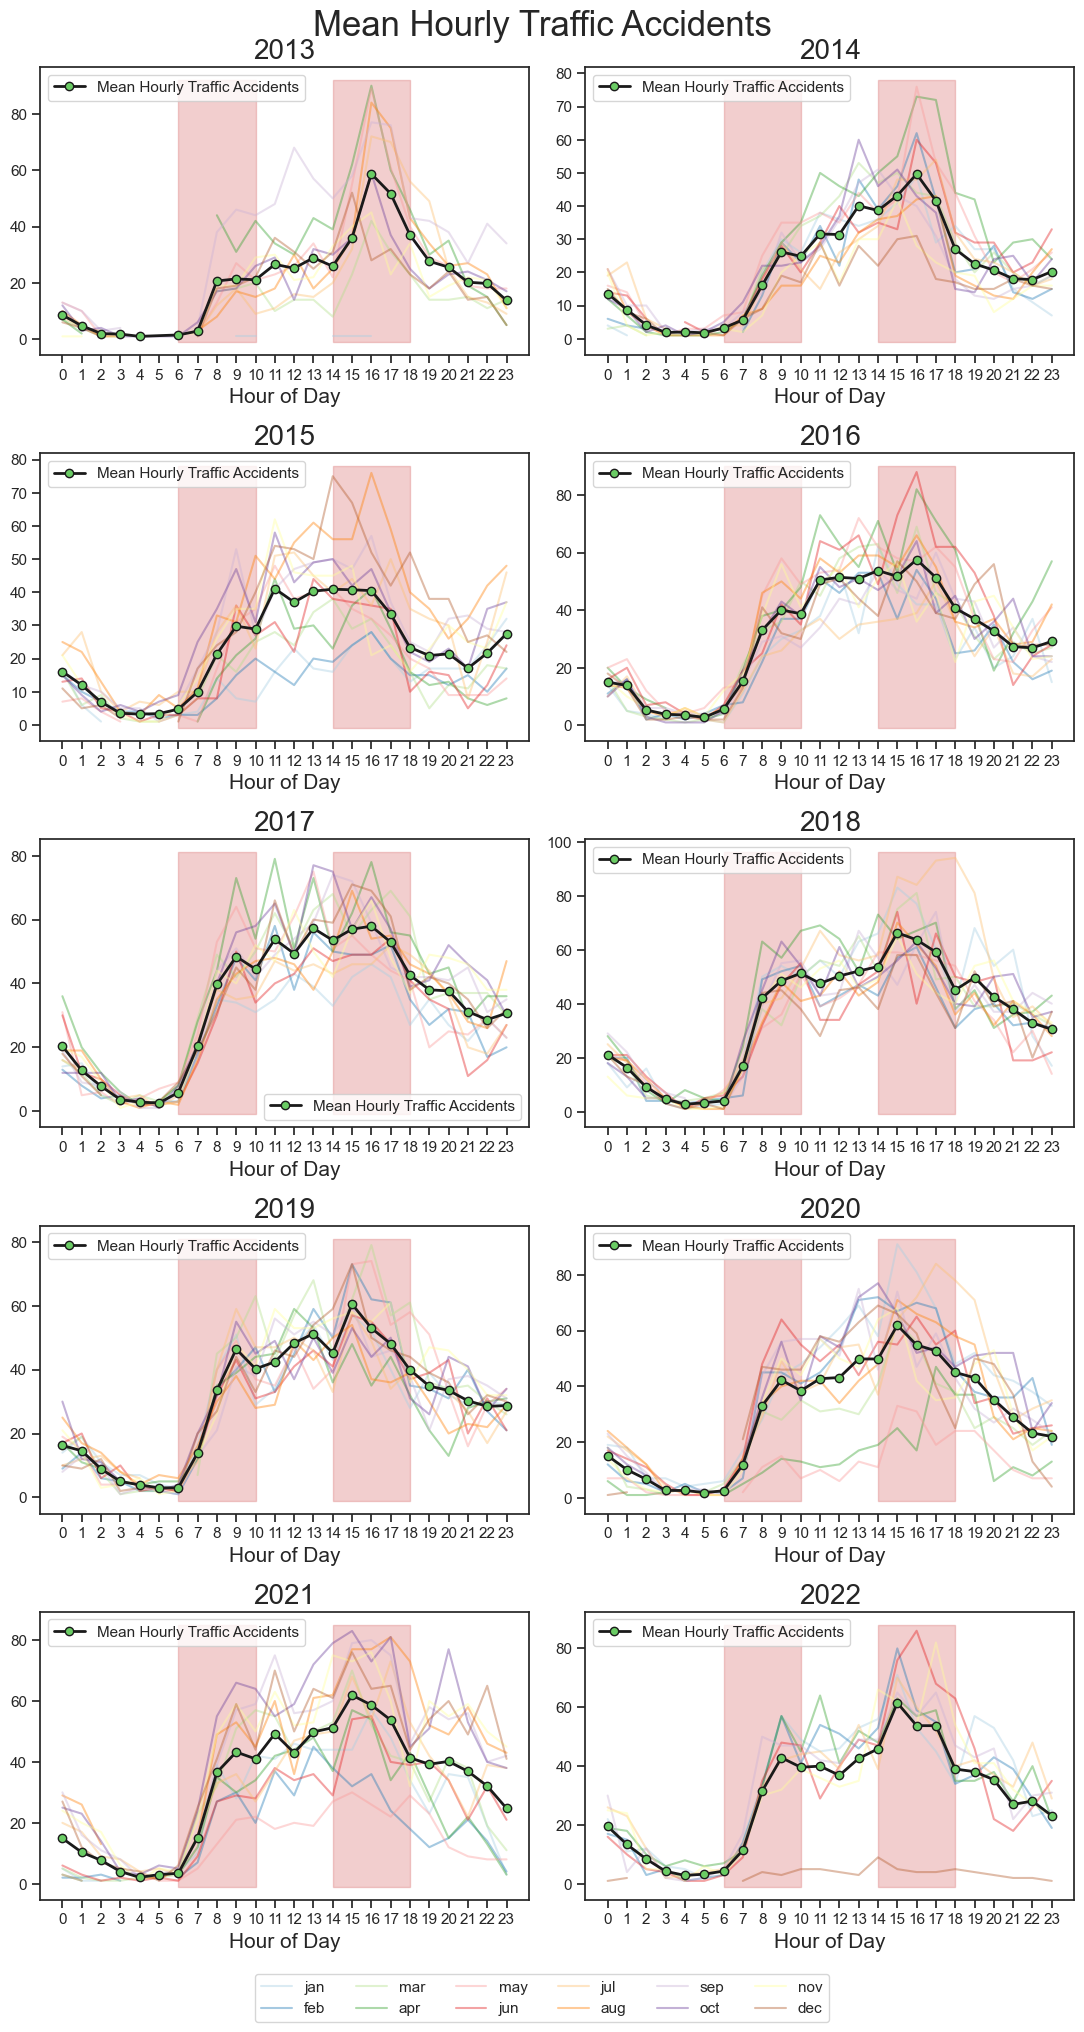

In [71]:
fig, axes = plt.subplots(5, 2, figsize=(11, 20), tight_layout=True)

for year, ax in zip(np.sort(df['YEAR'].unique()), axes.flatten()):
    
    temp_df = (
        df.query(f"ANNOUNCEMENT_TYPE_DESC=='Accident notification' and YEAR=={year}")
        .groupby(["MONTH", "HOUR"]).size()
        .unstack('MONTH')
    );

    # Getting upper and lower y limits for shading Accidents regions
    low_lim = temp_df.min(axis=1).min() - 2
    max_lim = temp_df.max(axis=1).max() + 2

    # Monthly Mean plots
    temp_df.plot(ax=ax, colormap='Paired', alpha=0.4)

    # Overall Mean plot
    temp_df.mean(axis=1).plot(ax=ax, c='k', lw=2, marker="o", mfc="g", mec="k", label='Mean Hourly Traffic Accidents')

    # To display on the Overall Mean plot legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-1:], labels[-1:])

    # Shading Regions of peak Traffic Accidents
    ax.fill_between(x=(6, 10), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)
    ax.fill_between(x=(14, 18), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)


    ax.set_title(year)
    ax.set_xticks(ticks=np.arange(0, 24, 1))
    ax.set_xlabel("Hour of Day")

# To display Month legends
handles, _ = axes.flatten()[1].get_legend_handles_labels()
fig.legend(handles=handles, labels=month_labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.03));

plt.suptitle("Mean Hourly Traffic Accidents", size=25);

### There is a very clear hourly patterns to accidents (based on the accident announcements). The first peak accidents happens betweem 6am to 10am. Followed by a higher peak between 2pm and 6pm.

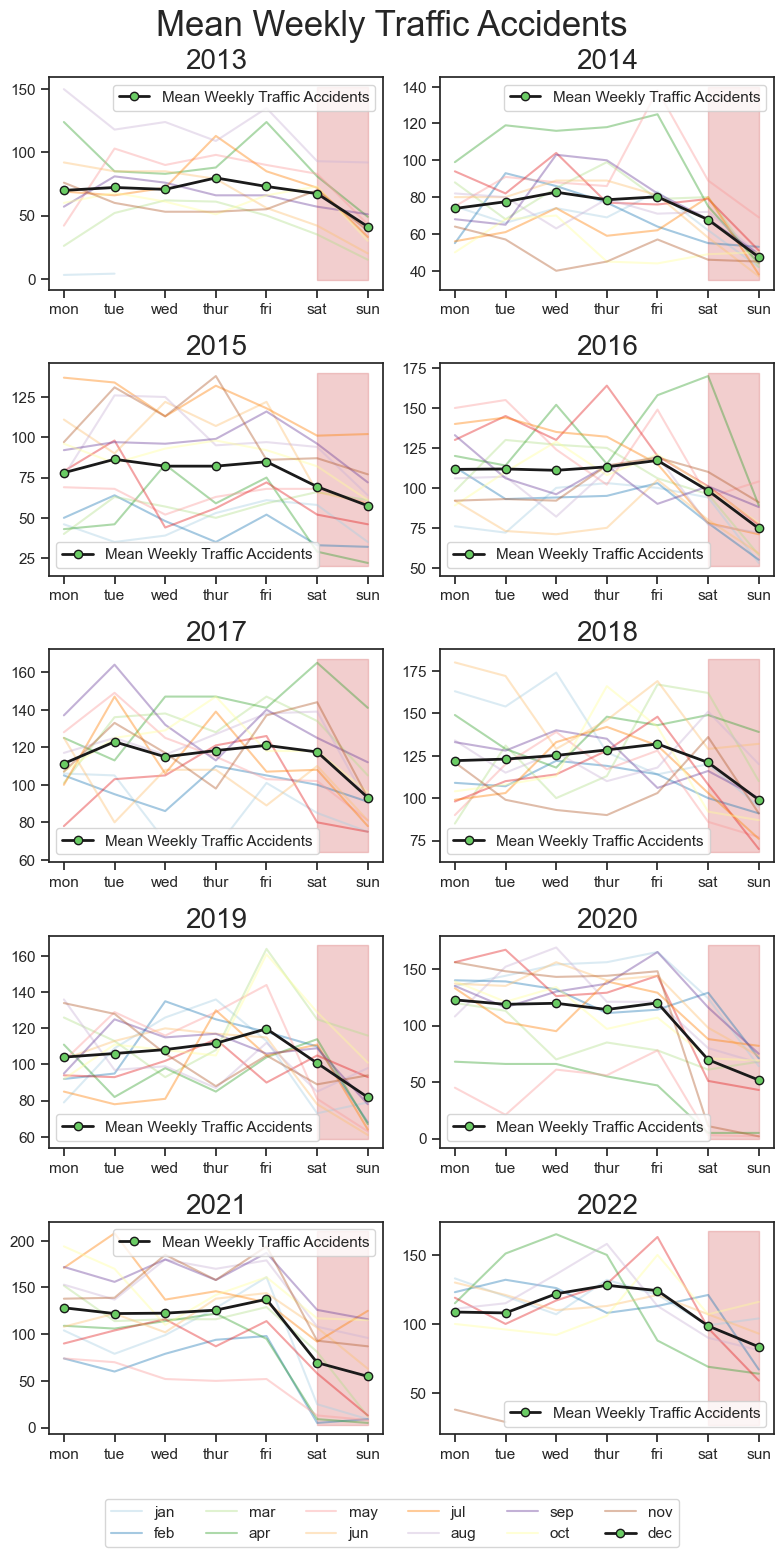

In [72]:
# Plotting Weekly Pattern
weekday_labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"]

fig, axes = plt.subplots(5, 2, figsize=(8, 15), tight_layout=True)

for year, ax in zip(np.sort(df['YEAR'].unique()), axes.flatten()):

    # Filtering year, followed by grouping by Month and day of week and taking avg traffic Accidents. Then saving it to a temp df
    temp_df=(
        df.query(f"ANNOUNCEMENT_TYPE_DESC=='Accident notification' and YEAR=={year}")
        .groupby(['MONTH', 'DAYOFWEEK']).size()
        .unstack('MONTH')
    )

    # Getting upper and lower y limits for shading density regions
    low_lim = temp_df.min(axis=1).min() - 2
    max_lim = temp_df.max(axis=1).max() + 2

    # Monthly Mean plots
    temp_df.plot(ax=ax, colormap='Paired', alpha=0.4)

    # Overall Mean plot
    temp_df.mean(axis=1).plot(ax=ax, c='k', lw=2, marker="o", mfc="g", mec="k", label='Mean Weekly Traffic Accidents')
    
    # To display on the Overall Mean plot legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-1:], labels[-1:])

    # Shading Regions of low Traffic Accidents
    ax.fill_between(x=(5, 6), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)

    ax.set_title(year)
    ax.set_xticks(ticks=np.arange(0, 7, 1), labels=weekday_labels)
    ax.set_xlabel("")

# To display Month legends
handles, _ = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=month_labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("Mean Weekly Traffic Accidents", size=25);

### There is a clear weekly pattern to accidents. Weekends sees lower accident rates compares to weekdays.

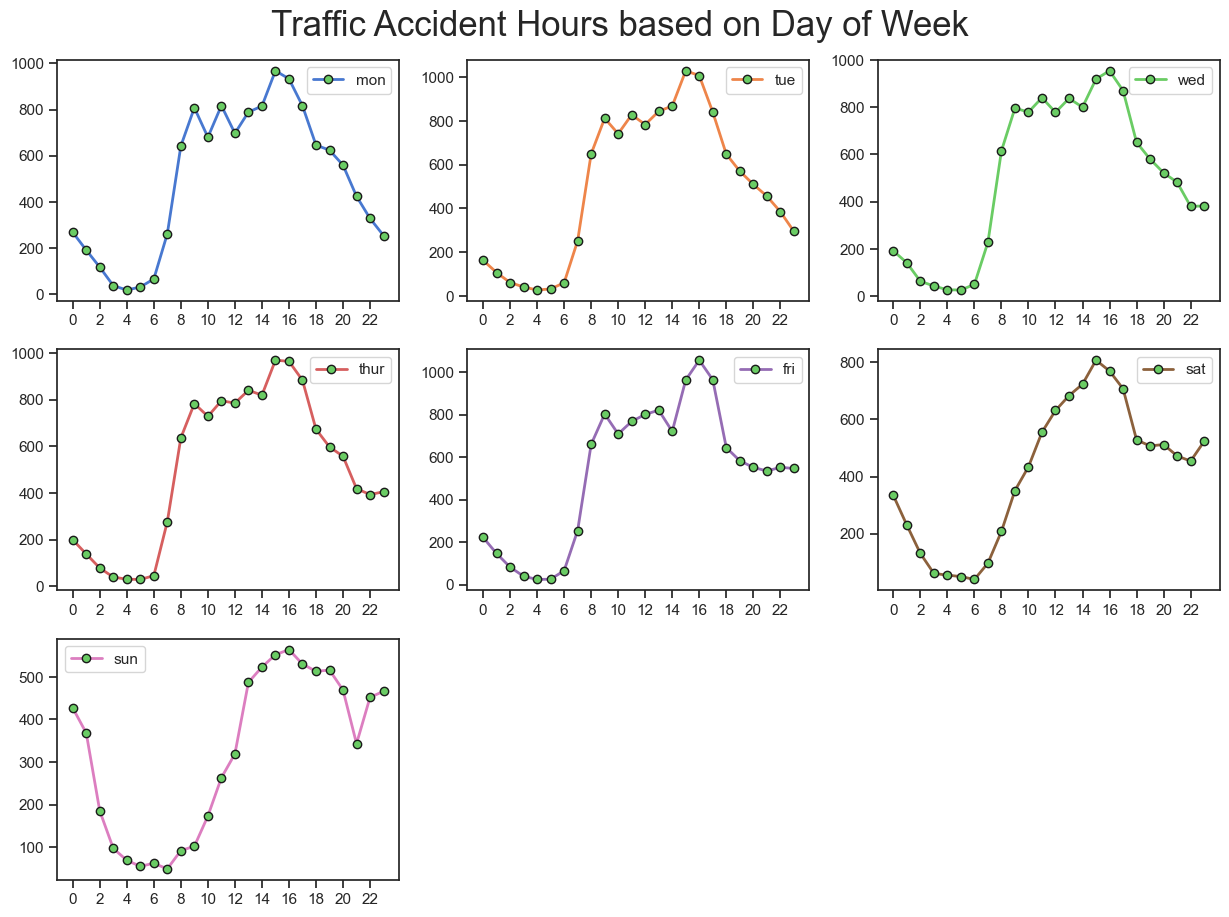

In [73]:
# Plotting Hourly pattern by day of week
axes = (
    df.query("ANNOUNCEMENT_TYPE_DESC=='Accident notification'")
    .groupby(['DAYOFWEEK', 'HOUR']).size()
    .unstack('DAYOFWEEK')
    .plot(subplots=True, figsize=(15, 10), layout=(3, 3), sharex=False, lw=2, marker="o", mfc="g", mec="k")
)

for i, ax in enumerate(axes.flatten()[:7]):
    ax.set_xlabel("")
    ax.set_xticks(np.arange(0, 24, 2))
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, [weekday_labels[i]])

plt.suptitle("Traffic Accident Hours based on Day of Week", fontsize=25)
plt.subplots_adjust(top=0.93);

### Accident hours do differ by the day of week. 

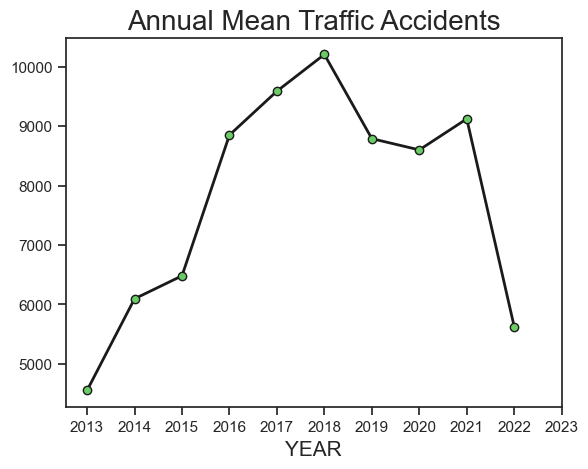

In [74]:
# Annual Pattern
ax = df.query("ANNOUNCEMENT_TYPE_DESC=='Accident notification'").groupby('YEAR').size().plot(c='k', lw=2, marker="o", mfc="g", mec="k")
ax.set_xticks(np.arange(2013, 2024, 1))
ax.set_title("Annual Mean Traffic Accidents");

### Highest number of accidents were announced during 2018. Its not clear why accidents rates were low from 2013 to 2015. Perhaps not enough traffic incidents related to accidents were recorded?